In [40]:
!pip install jovian --upgrade --quiet

In [2]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor,transforms,Resize
from torchvision import transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

In [3]:
project_name='monkey-species'

In [4]:
train_data_dir='../input/10-monkey-species/training'
test_data_dir='../input/10-monkey-species/validation'

In [6]:
print(os.listdir(train_data_dir+'/training'))

['n4', 'n3', 'n9', 'n6', 'n5', 'n1', 'n7', 'n2', 'n0', 'n8']


In [7]:
print(os.listdir(test_data_dir+'/validation'))

['n4', 'n3', 'n9', 'n6', 'n5', 'n1', 'n7', 'n2', 'n0', 'n8']


In [8]:
train_dir=os.listdir(train_data_dir + "/training")
for i in train_dir:
    count=os.listdir(train_data_dir + "/training/"+i)
    print('No. of training examples for '+i, len(count))

No. of training examples for n4 105
No. of training examples for n3 122
No. of training examples for n9 106
No. of training examples for n6 106
No. of training examples for n5 113
No. of training examples for n1 111
No. of training examples for n7 114
No. of training examples for n2 110
No. of training examples for n0 105
No. of training examples for n8 106


In [9]:
test_dir=os.listdir(test_data_dir + "/validation")
for i in test_dir:
    count=os.listdir(test_data_dir + "/validation/"+i)
    print('No. of testing examples for '+i, len(count))

No. of testing examples for n4 26
No. of testing examples for n3 30
No. of testing examples for n9 26
No. of testing examples for n6 26
No. of testing examples for n5 28
No. of testing examples for n1 28
No. of testing examples for n7 28
No. of testing examples for n2 27
No. of testing examples for n0 26
No. of testing examples for n8 27


In [11]:
import jovian

<IPython.core.display.Javascript object>

In [11]:
jovian.commit(project=project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/aasawaribhavsar/monkey-species


<IPython.core.display.Javascript object>

In [12]:
#imagenet_stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [10]:
train_dataset = ImageFolder(train_data_dir + "/training", transforms.Compose([
    transforms.Resize((512,512)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
   
]))

In [11]:
img, label = train_dataset[0]
print(img.shape, label)
img

torch.Size([3, 512, 512]) 0


tensor([[[0.6078, 0.5922, 0.8000,  ..., 0.3961, 0.4078, 0.4157],
         [0.5804, 0.5176, 0.6510,  ..., 0.4000, 0.4118, 0.4157],
         [0.5686, 0.4784, 0.5176,  ..., 0.4039, 0.4118, 0.4157],
         ...,
         [0.4235, 0.4706, 0.3608,  ..., 0.8431, 0.8588, 0.8706],
         [0.4471, 0.4980, 0.4157,  ..., 0.8353, 0.8510, 0.8627],
         [0.4706, 0.4941, 0.4510,  ..., 0.8275, 0.8471, 0.8588]],

        [[0.5529, 0.5608, 0.7961,  ..., 0.3843, 0.3882, 0.3922],
         [0.5333, 0.4941, 0.6510,  ..., 0.3843, 0.3882, 0.3922],
         [0.5373, 0.4667, 0.5255,  ..., 0.3843, 0.3882, 0.3922],
         ...,
         [0.3176, 0.3686, 0.2706,  ..., 0.8667, 0.8824, 0.8980],
         [0.3373, 0.3961, 0.3216,  ..., 0.8588, 0.8784, 0.8902],
         [0.3569, 0.3922, 0.3608,  ..., 0.8510, 0.8745, 0.8863]],

        [[0.1765, 0.2000, 0.4706,  ..., 0.1765, 0.1843, 0.1882],
         [0.1373, 0.1137, 0.2980,  ..., 0.1804, 0.1843, 0.1882],
         [0.1059, 0.0549, 0.1451,  ..., 0.1804, 0.1843, 0.

In [12]:
names=['mantled_howler','patas_monkey','bald_uakari','japanese_macaque','pygmy_marmoset','white_headed_capuchin','silvery_marmoset','common_squirrel_monkey','black_headed_night_monkey','nilgiri_langur']

In [13]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', names[label],"("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  pygmy_marmoset (4)


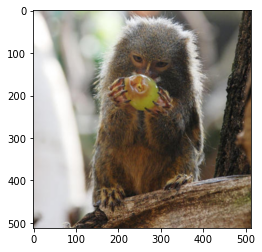

In [14]:
show_example(*train_dataset[500])

Label:  nilgiri_langur (9)


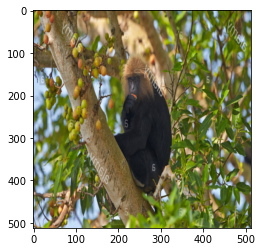

In [15]:
show_example(*train_dataset[1000])

In [82]:
jovian.commit(project=project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/aasawaribhavsar/monkey-species


<IPython.core.display.Javascript object>

In [16]:
random_seed = 42
torch.manual_seed(random_seed);

In [17]:
val_dataset = ImageFolder(test_data_dir + "/validation", transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    
]))

In [18]:
batch_size = 128

In [19]:
# PyTorch data loaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_dataset, batch_size*2, num_workers=3, pin_memory=True)

In [20]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

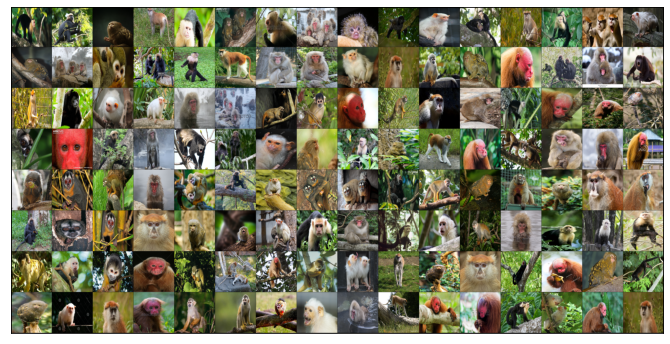

In [21]:
show_batch(train_dl)

In [120]:
jovian.commit(project=project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/aasawaribhavsar/monkey-species


<IPython.core.display.Javascript object>

In [22]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [23]:
device = get_default_device()
device

device(type='cuda')

In [24]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [161]:
jovian.commit(project=project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/aasawaribhavsar/monkey-species


<IPython.core.display.Javascript object>

In [26]:
class MonkeycnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
       
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [27]:
model = MonkeycnnModel()
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


MonkeycnnModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [28]:
model=to_device(model, device)

In [29]:
def try_batch(dl):
    for images, labels in dl:
        print('images.shape:', images.shape)
        out = model(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[0])
        break

try_batch(train_dl)

images.shape: torch.Size([128, 3, 512, 512])
out.shape: torch.Size([128, 10])
out[0]: tensor([0.5974, 0.5949, 0.6349, 0.4076, 0.5504, 0.7034, 0.5275, 0.7385, 0.4448,
        0.5233], device='cuda:0', grad_fn=<SelectBackward>)


In [30]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [31]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.306147575378418, 'val_acc': 0.048828125}]

In [32]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [33]:
model.freeze()

In [34]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], train_loss: 1.8976, val_loss: 2.4673, val_acc: 0.1133



Epoch [1], train_loss: 1.6901, val_loss: 1.9326, val_acc: 0.5312



Epoch [2], train_loss: 1.8593, val_loss: 2.4899, val_acc: 0.0527



Epoch [3], train_loss: 1.7843, val_loss: 2.0357, val_acc: 0.0527



Epoch [4], train_loss: 1.7127, val_loss: 2.4752, val_acc: 0.0879



Epoch [5], train_loss: 1.6440, val_loss: 1.6587, val_acc: 0.8633



Epoch [6], train_loss: 1.5837, val_loss: 1.7141, val_acc: 0.7461



Epoch [7], train_loss: 1.5568, val_loss: 1.6823, val_acc: 0.8164



Epoch [8], train_loss: 1.5261, val_loss: 1.5999, val_acc: 0.8848



Epoch [9], train_loss: 1.5214, val_loss: 1.5892, val_acc: 0.8848
CPU times: user 35.2 s, sys: 28.3 s, total: 1min 3s
Wall time: 14min


In [35]:
model.unfreeze()

In [36]:
%%time
history += fit_one_cycle(epochs, 0.001, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], train_loss: 1.5140, val_loss: 1.5757, val_acc: 0.8906



Epoch [1], train_loss: 1.5092, val_loss: 1.5922, val_acc: 0.9121



Epoch [2], train_loss: 1.4995, val_loss: 1.6495, val_acc: 0.8516



Epoch [3], train_loss: 1.4992, val_loss: 1.6066, val_acc: 0.8516



Epoch [4], train_loss: 1.4989, val_loss: 1.5690, val_acc: 0.8906



Epoch [5], train_loss: 1.4957, val_loss: 1.5967, val_acc: 0.8711



Epoch [6], train_loss: 1.4846, val_loss: 1.5350, val_acc: 0.9609



Epoch [7], train_loss: 1.4796, val_loss: 1.5283, val_acc: 0.9707



Epoch [8], train_loss: 1.4757, val_loss: 1.5146, val_acc: 0.9707



Epoch [9], train_loss: 1.4741, val_loss: 1.5124, val_acc: 0.9707
CPU times: user 31.7 s, sys: 26.4 s, total: 58.2 s
Wall time: 14min


In [41]:
import jovian

<IPython.core.display.Javascript object>

In [42]:
jovian.commit(project=project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/aasawaribhavsar/monkey-species


<IPython.core.display.Javascript object>

In [62]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

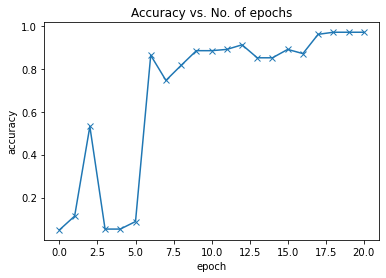

In [63]:
plot_accuracies(history)

In [64]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

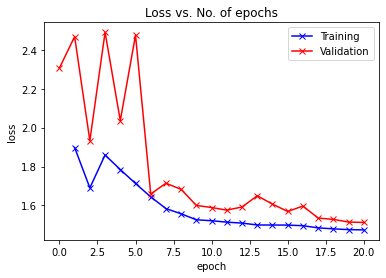

In [65]:
plot_losses(history)

In [53]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return names[preds[0].item()]

Label: mantled_howler , Predicted: mantled_howler


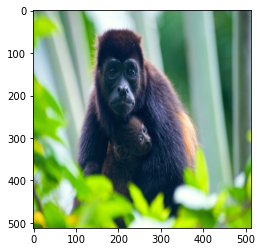

In [55]:
img, label = val_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', names[label], ', Predicted:', predict_image(img, model))

Label: japanese_macaque , Predicted: japanese_macaque


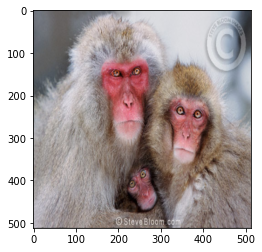

In [58]:
img, label = val_dataset[100]
plt.imshow(img.permute(1, 2, 0))
print('Label:', names[label], ', Predicted:', predict_image(img, model))

Label: common_squirrel_monkey , Predicted: common_squirrel_monkey


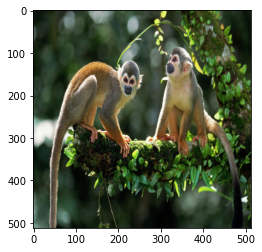

In [59]:
img, label = val_dataset[200]
plt.imshow(img.permute(1, 2, 0))
print('Label:', names[label], ', Predicted:', predict_image(img, model))

Label: silvery_marmoset , Predicted: silvery_marmoset


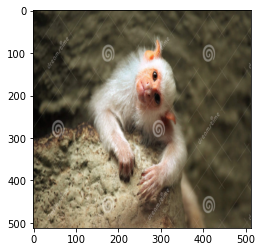

In [61]:
img, label = val_dataset[170]
plt.imshow(img.permute(1, 2, 0))
print('Label:', names[label], ', Predicted:', predict_image(img, model))

In [66]:
weights_fname = 'monkey-species-resnet.pth'
torch.save(model.state_dict(), weights_fname)

In [67]:
jovian.reset()
jovian.log_hyperparams(arch='resnet18', 
                       epochs=2*epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [69]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_score=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   )

[jovian] Metrics logged.


In [72]:
jovian.commit(project=project_name, environment=None, outputs=[weights_fname])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/aasawaribhavsar/monkey-species


<IPython.core.display.Javascript object>